In [22]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import os

In [23]:
scenario = ['PAK', 'RUS', 'HOA', 'URU', 'ALL']

df = [ pd.read_csv(scenario[i] + '-Losses.csv') for i in range(len(scenario)) ]
print(df[2].head())

          area                 item     amount [t]  absolute_losses [t]  \
0  Afghanistan                Abaca       0.000000         0.000000e+00   
1  Afghanistan    Alcohol, Non-Food     384.368696         1.641117e+03   
2  Afghanistan  Apples and products  273405.027171         8.470962e-04   
3  Afghanistan                Asses       0.000000         0.000000e+00   
4  Afghanistan              Bananas   97000.991410         8.178176e-08   

   relative_losses  al/capita [kg]  
0     0.000000e+00    0.000000e+00  
1     8.102338e-01    4.281991e-02  
2     3.098320e-09    2.210237e-08  
3     0.000000e+00    0.000000e+00  
4     8.431034e-13    2.133844e-12  


In [24]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

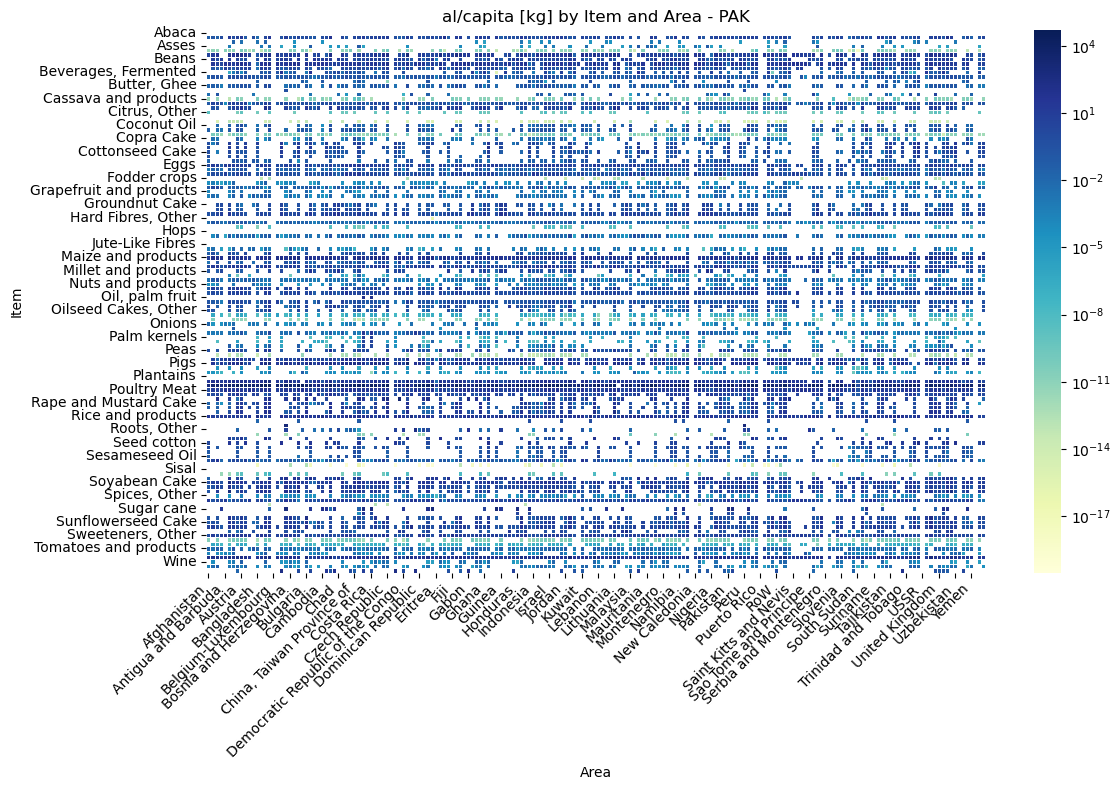

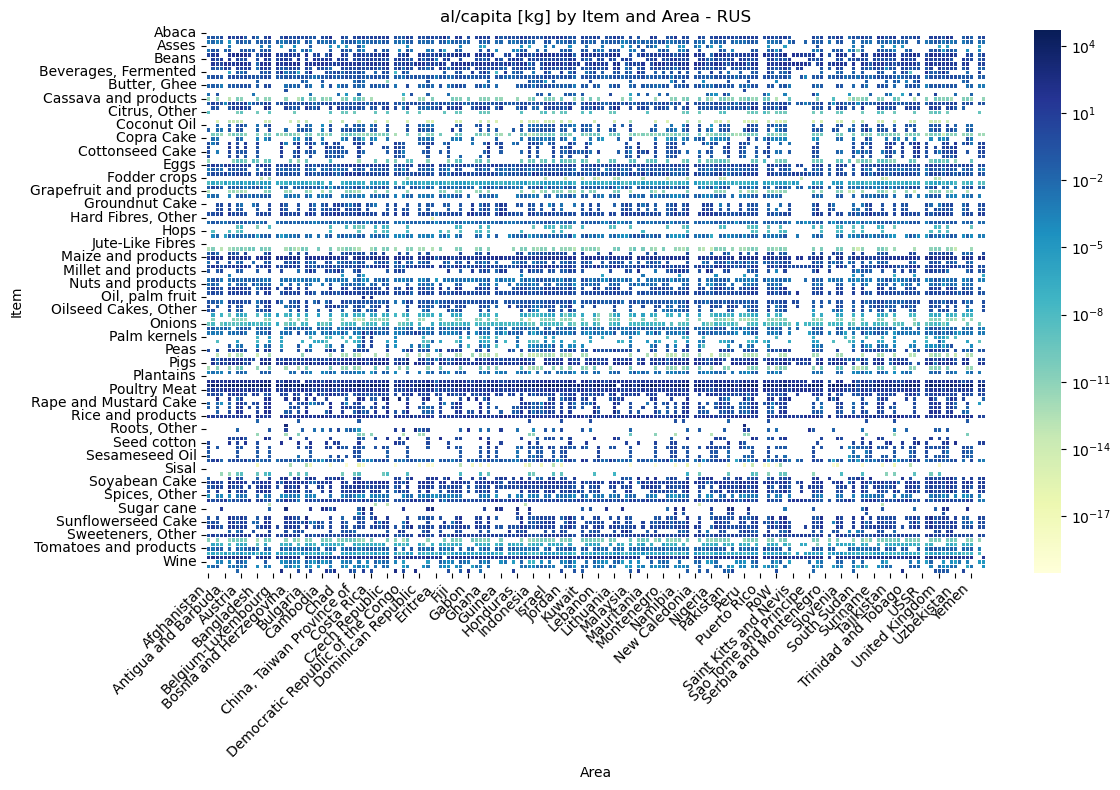

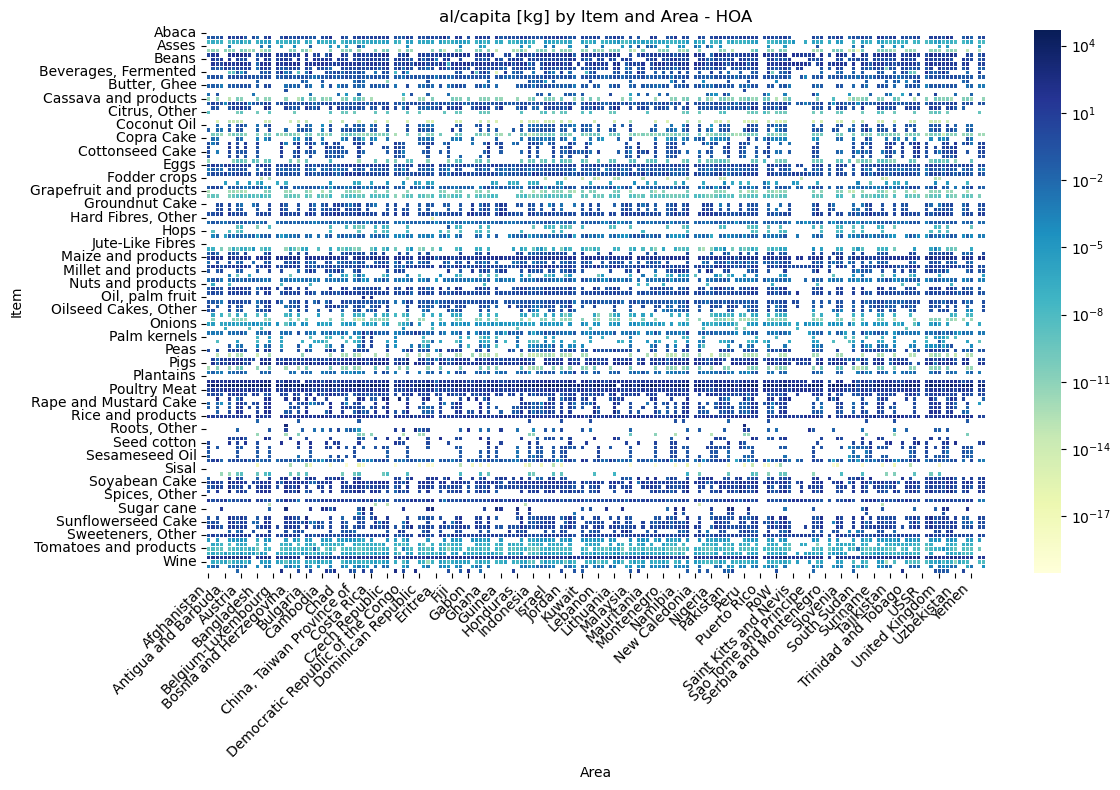

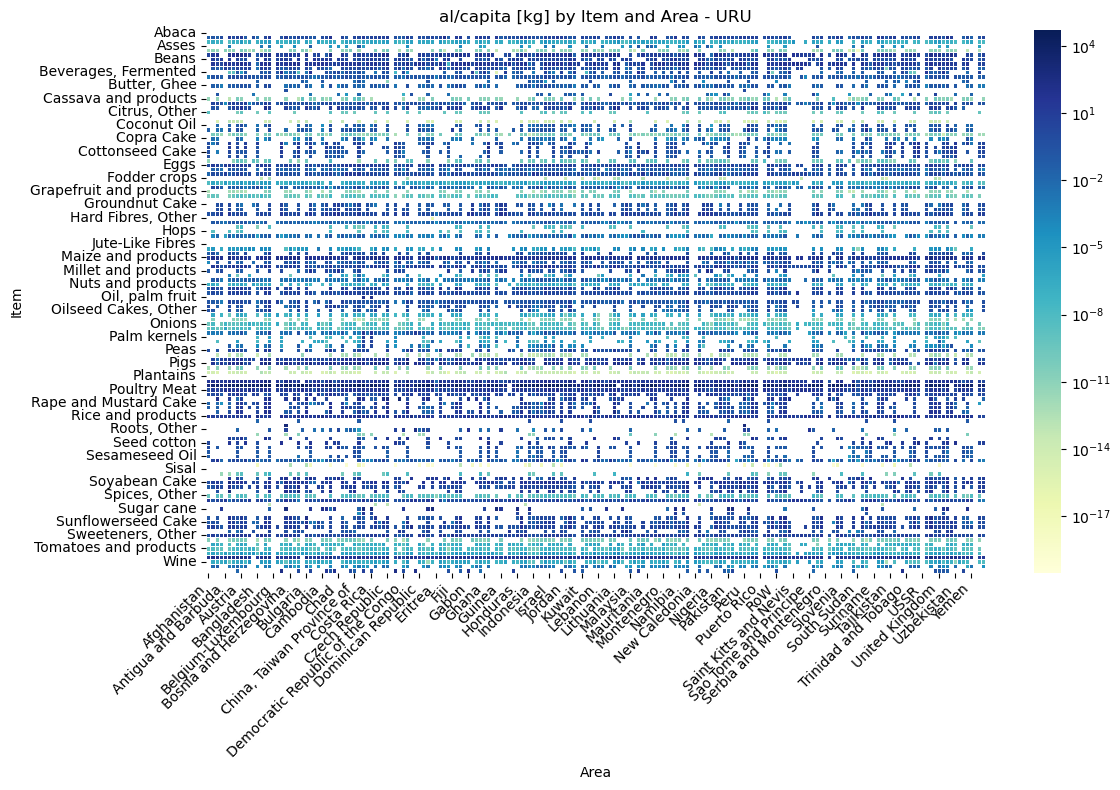

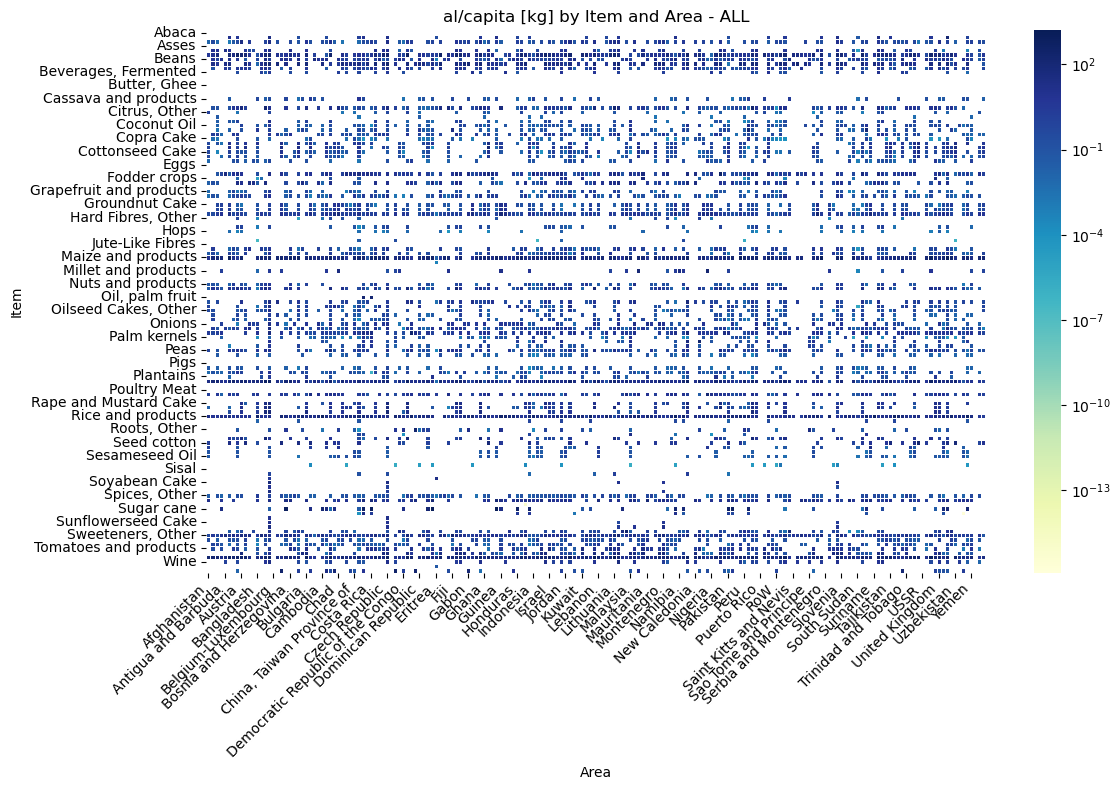

In [25]:
for i in range(len(scenario)):
    # Create pivot table
    pivot_table = df[i].pivot_table(
        index='item',
        columns='area',
        values='al/capita [kg]',
        aggfunc='sum',
        fill_value=0
    )

    # Replace zeros with NaN for log scale compatibility
    masked_data = pivot_table.replace(0, np.nan)

    # Get all positive values (ignoring NaN)
    positive_values = masked_data[masked_data > 0].values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    # Check for valid data
    vmin = positive_values.min() if len(positive_values) > 0 else 1e-6
    vmax = positive_values.max() if len(positive_values) > 0 else 1

    # Define a more varied color palette
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad(color='white')  # for NaN entries

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5
    )
    plot_title = f"al/capita [kg] by Item and Area - {scenario[i]}"
    plt.title(plot_title)
    plt.xlabel("Area")
    plt.ylabel("Item")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot
    filename = f"al_per_capita_{scenario[i].replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)

    plt.show()

/var/folders/fc/k0ssmt390m779swj1xmy_6lw0000gn/T/ipykernel_9332/2651376458.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



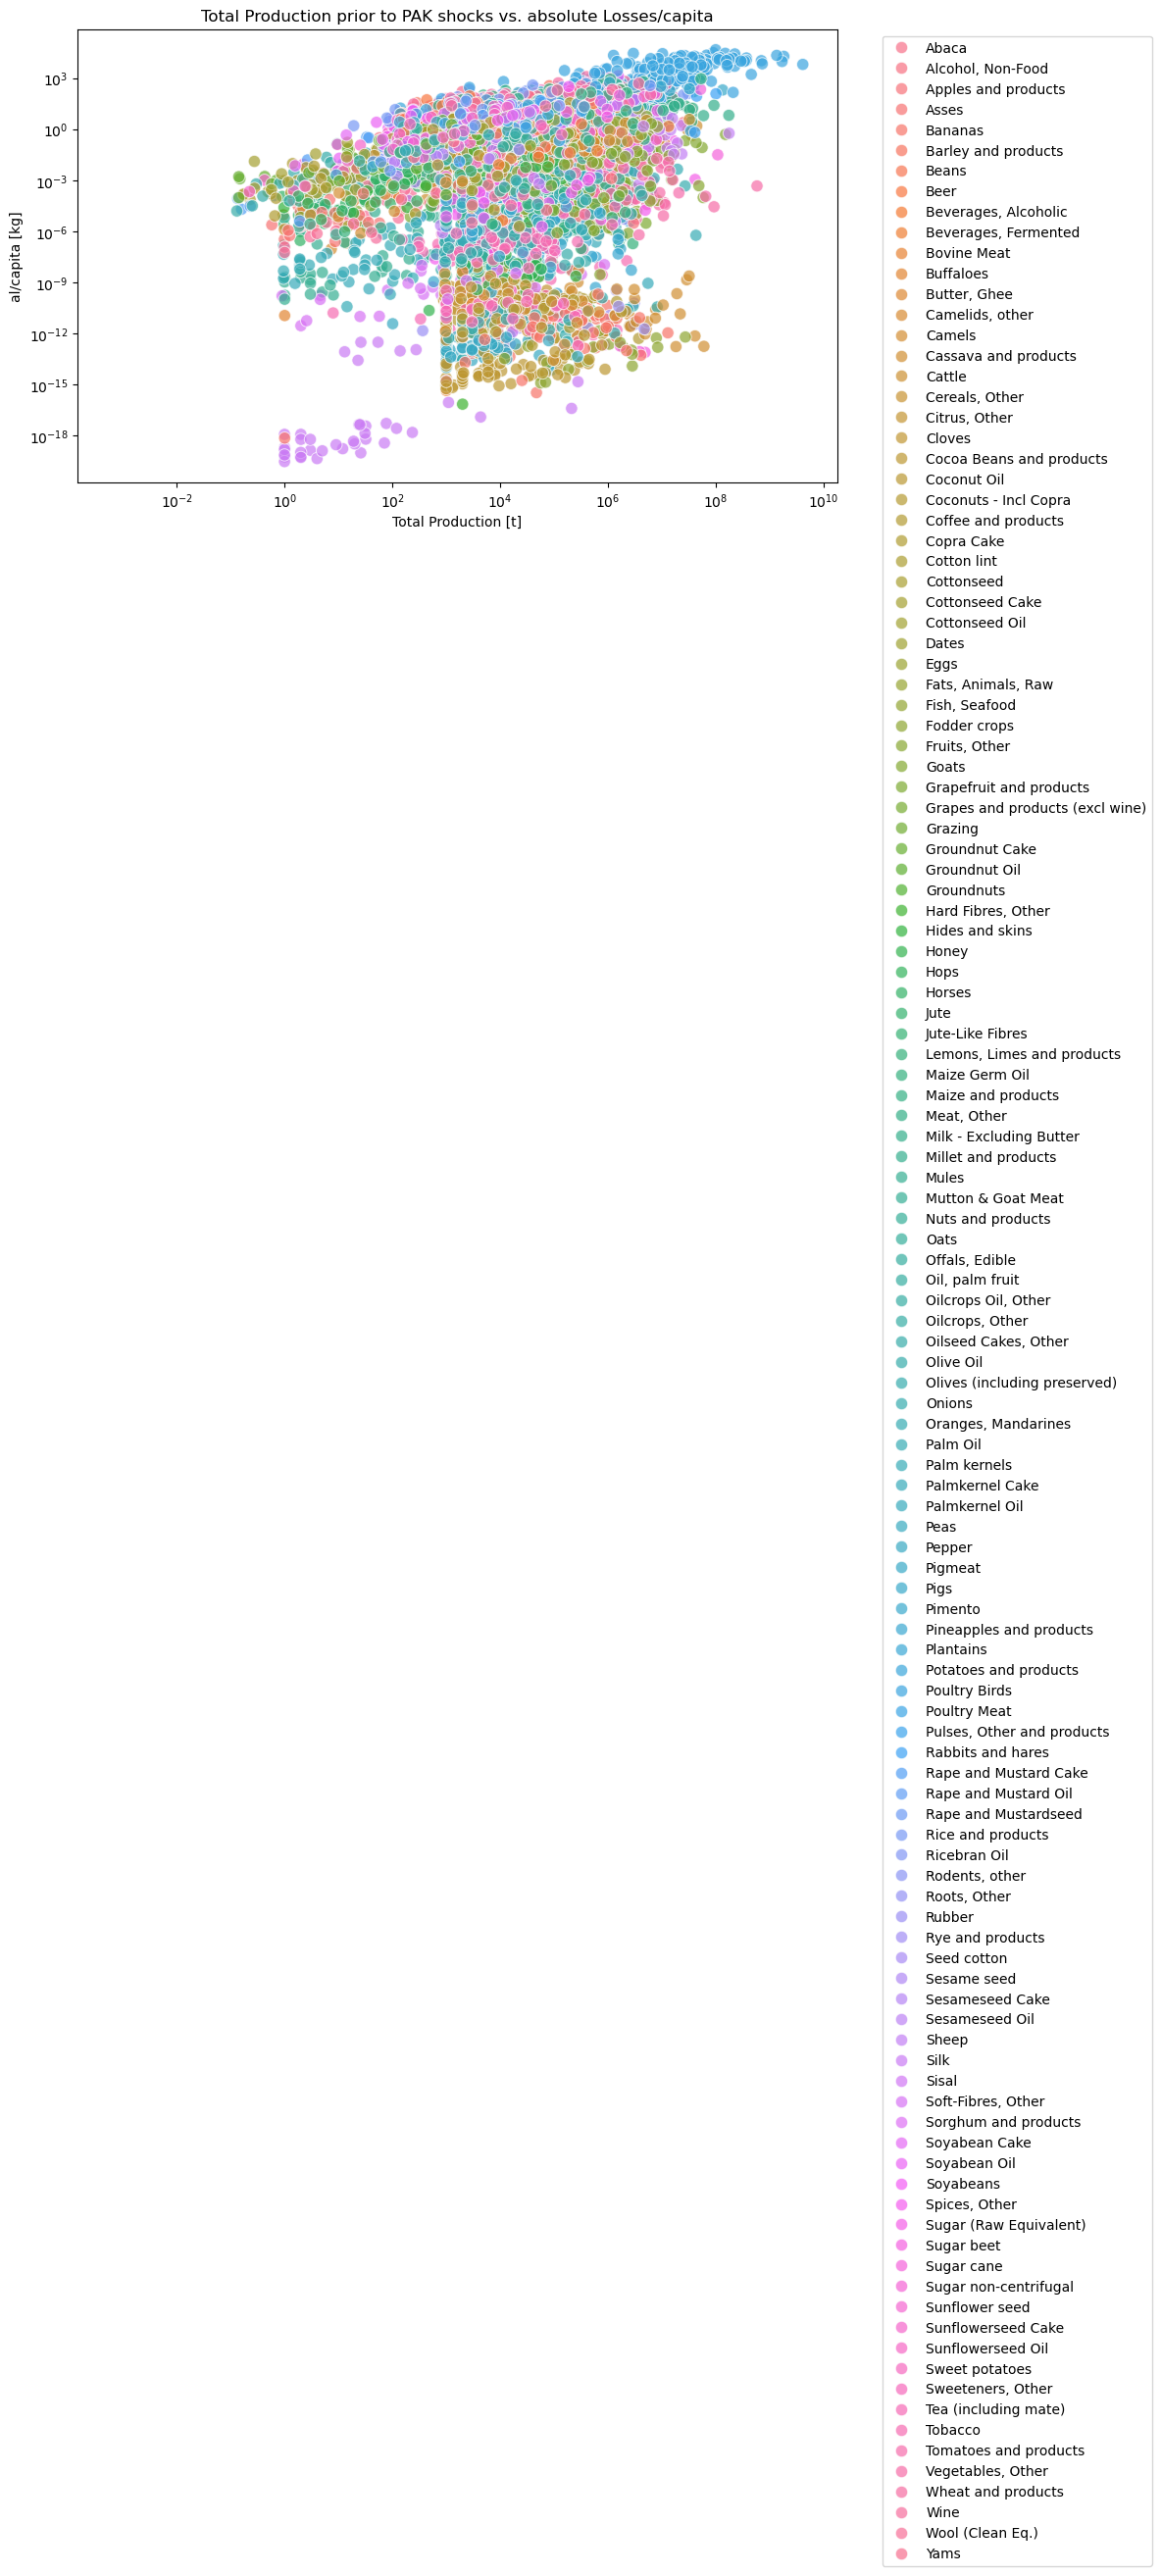

/var/folders/fc/k0ssmt390m779swj1xmy_6lw0000gn/T/ipykernel_9332/2651376458.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



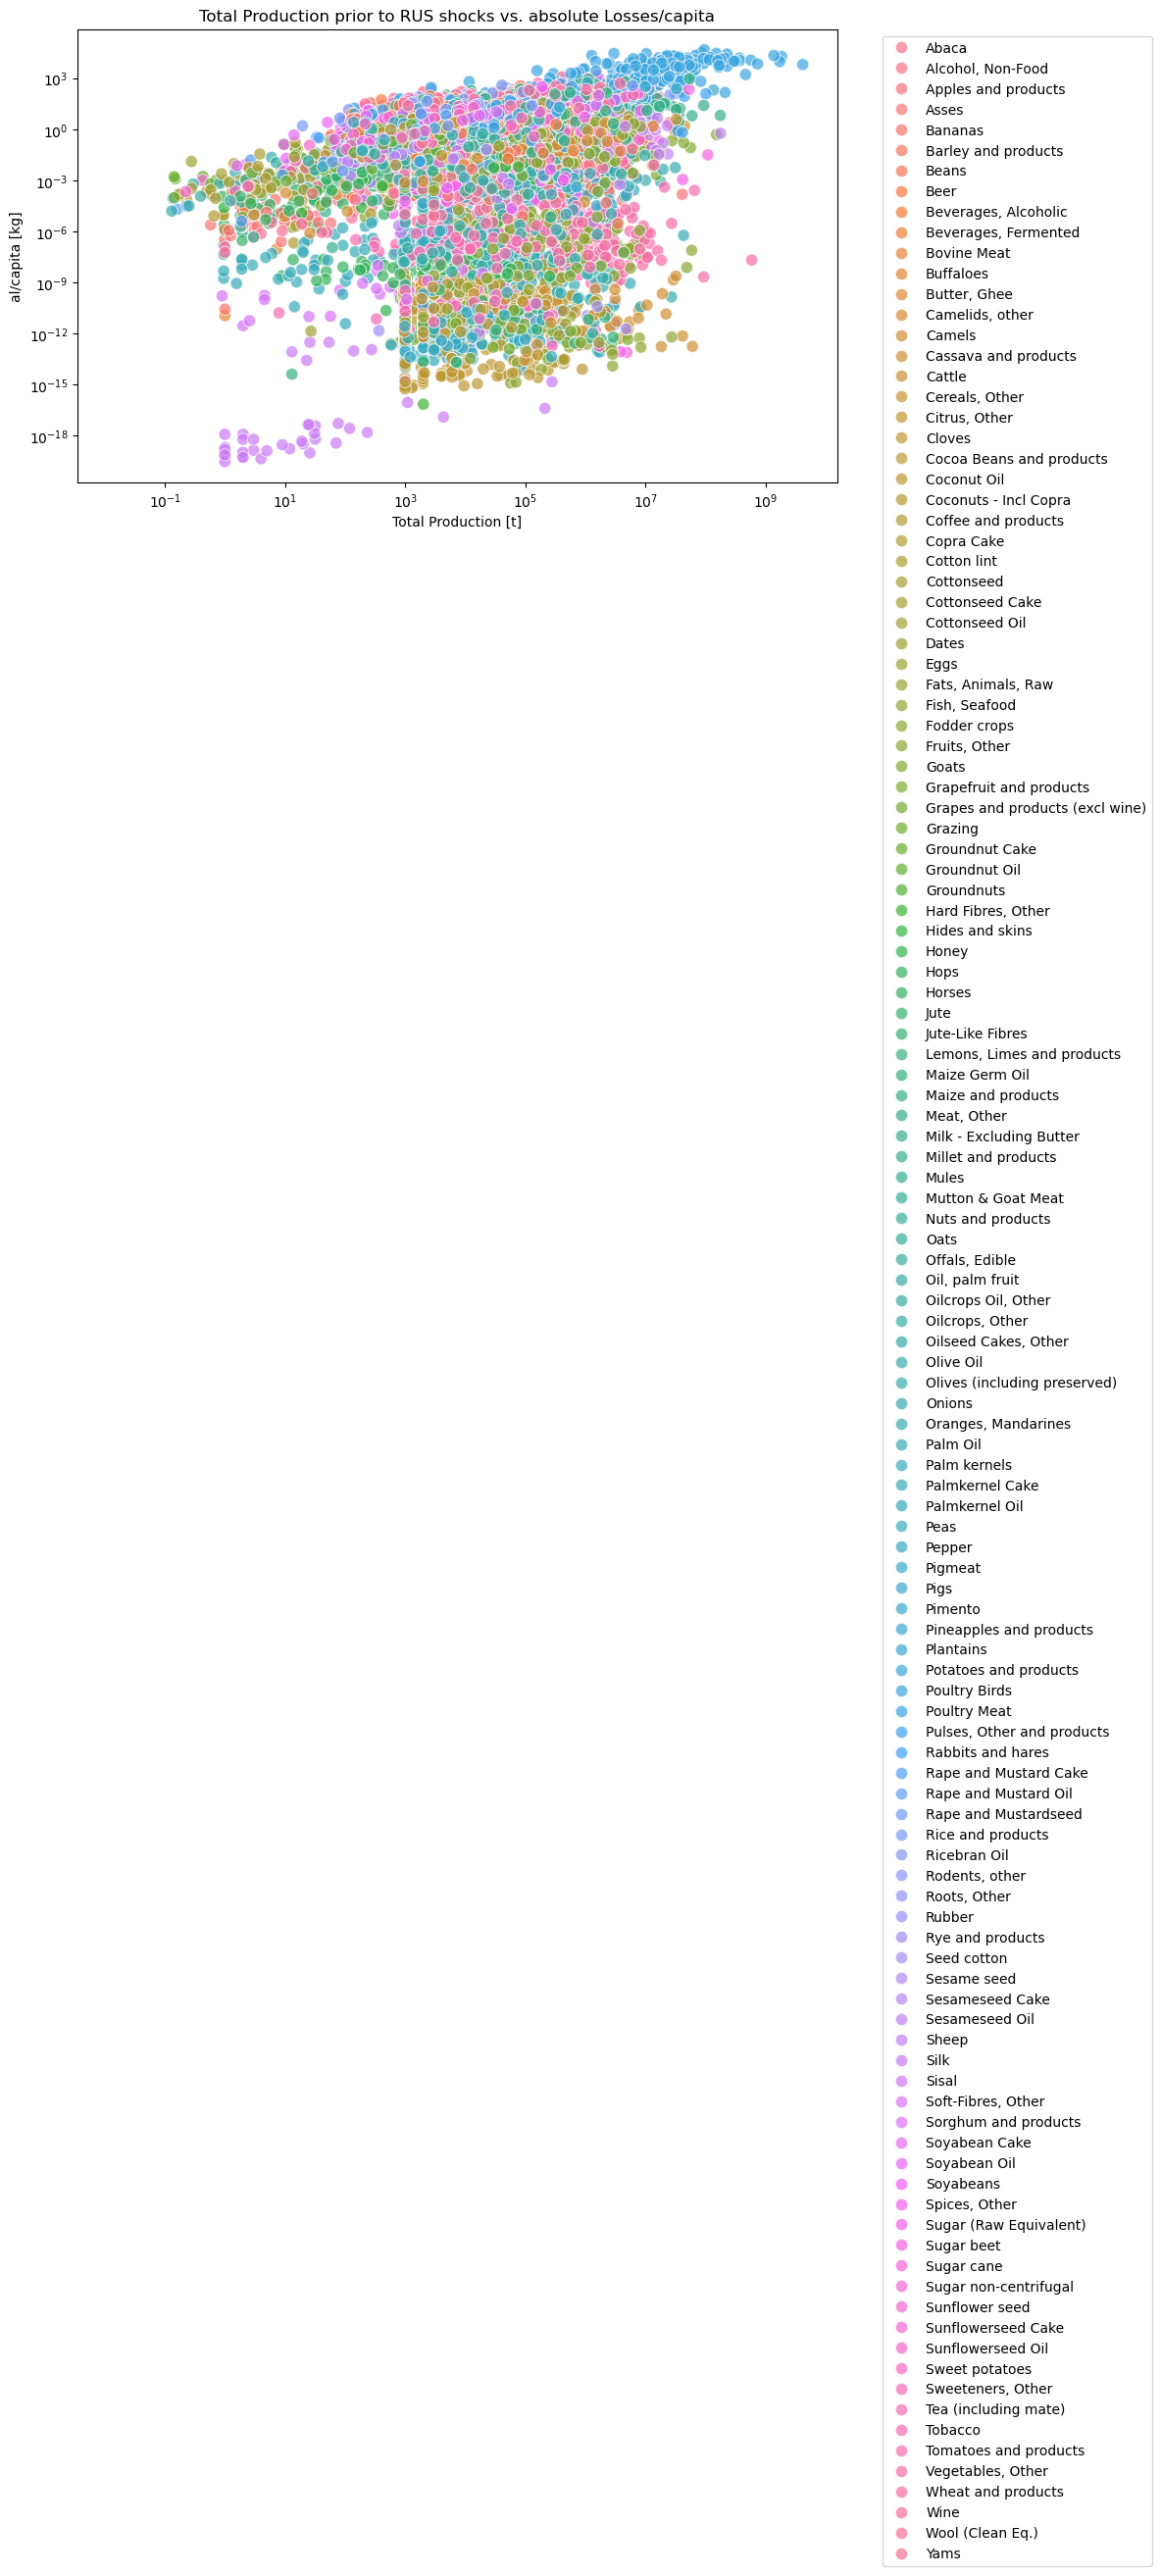

/var/folders/fc/k0ssmt390m779swj1xmy_6lw0000gn/T/ipykernel_9332/2651376458.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



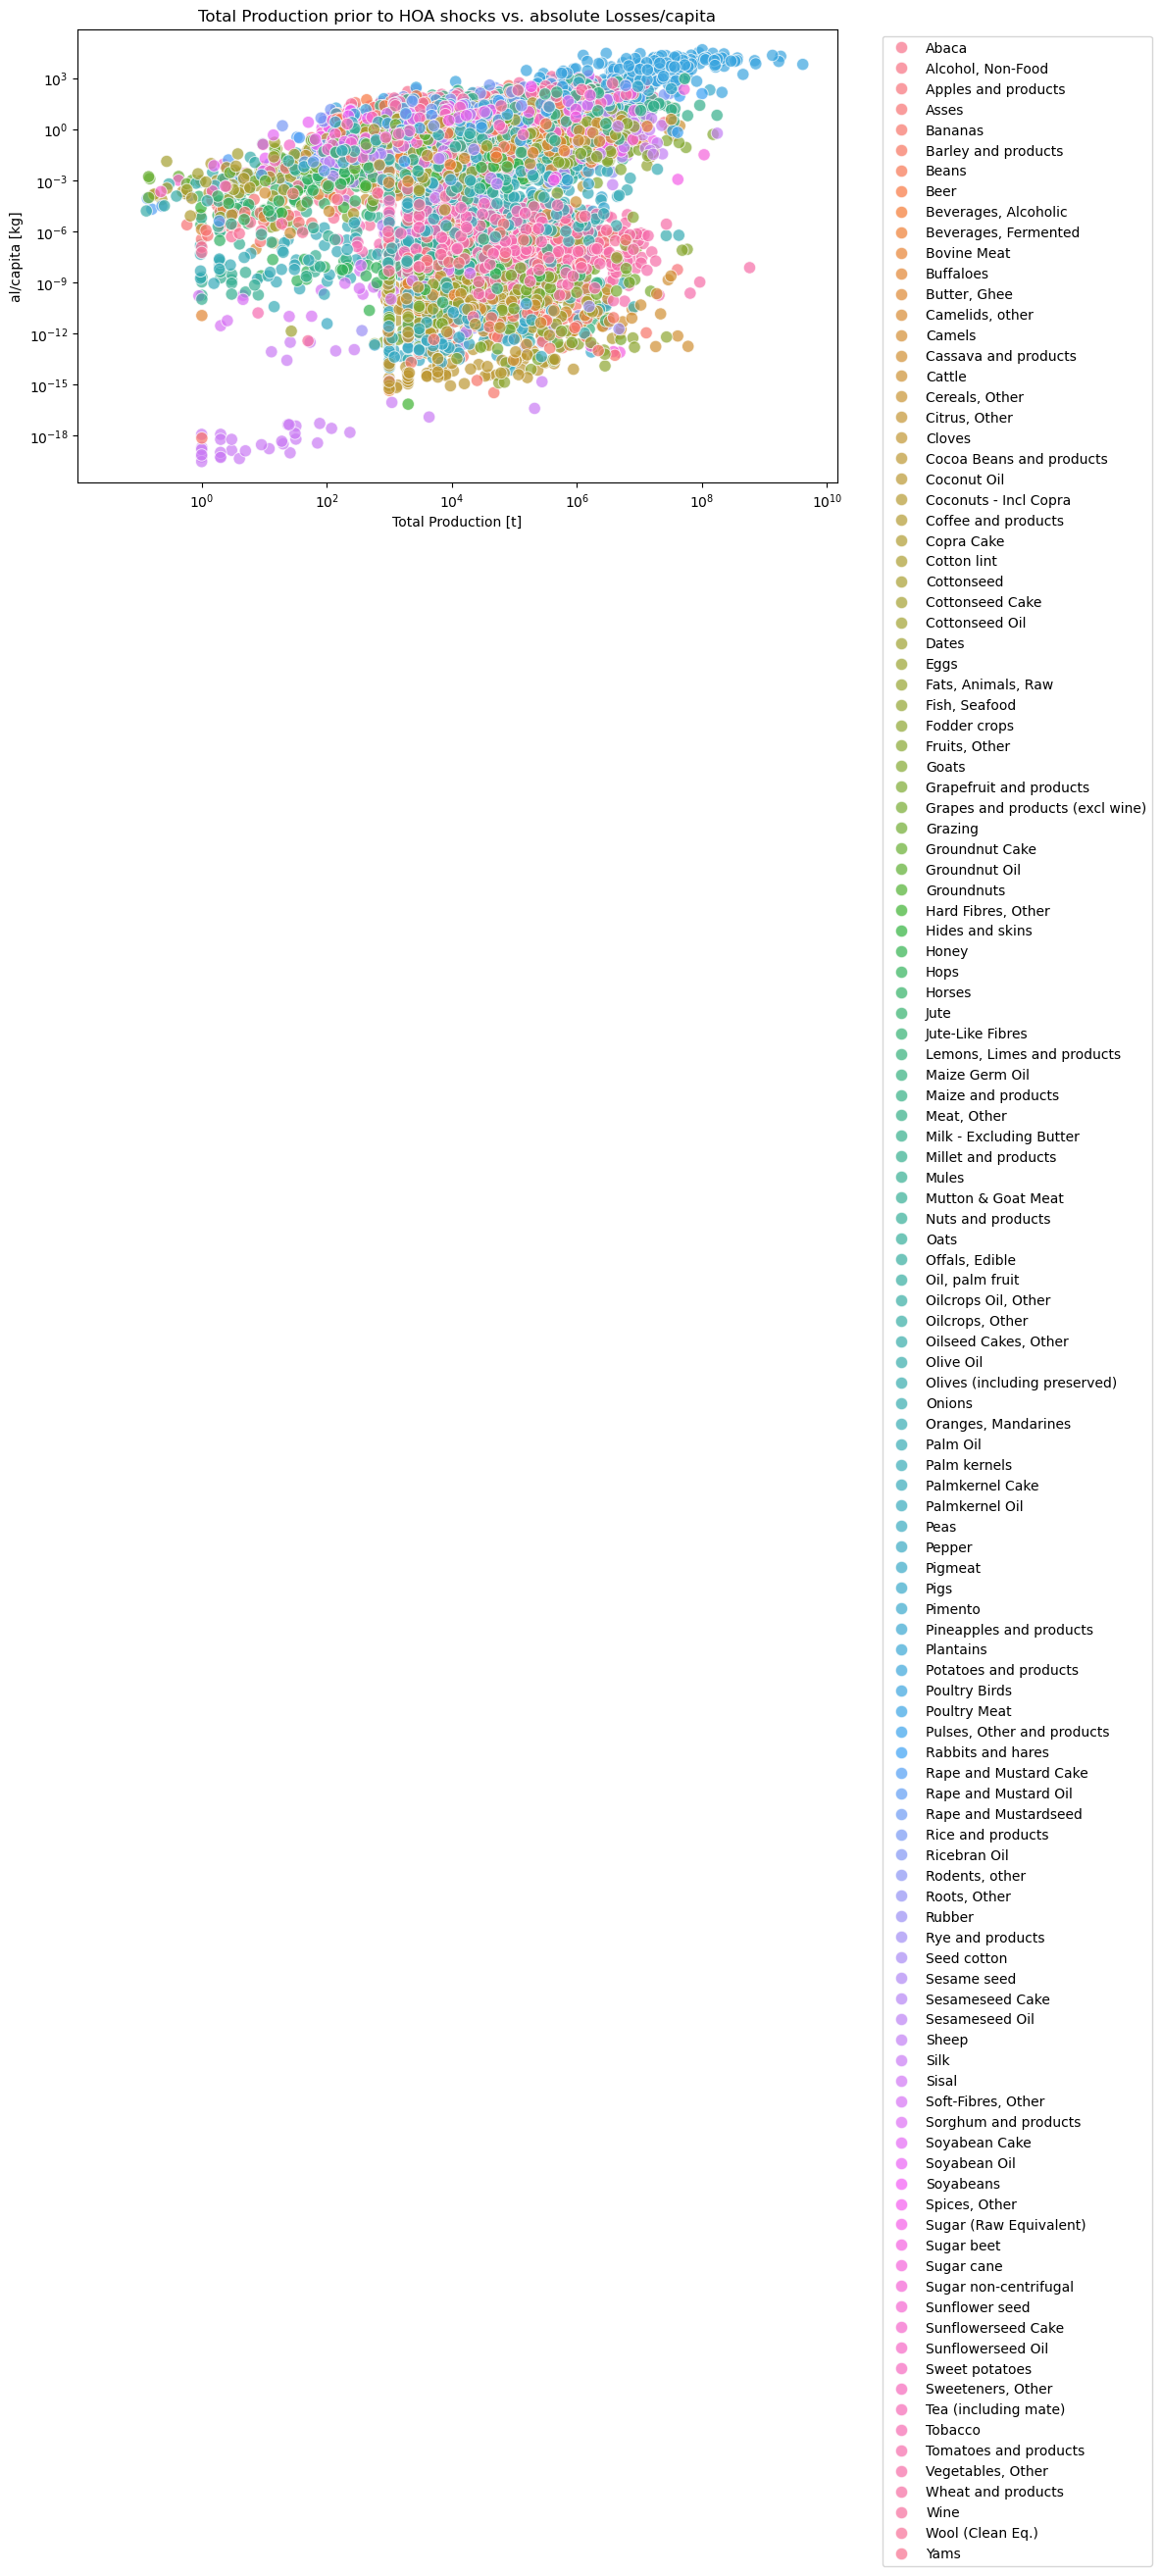

/var/folders/fc/k0ssmt390m779swj1xmy_6lw0000gn/T/ipykernel_9332/2651376458.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



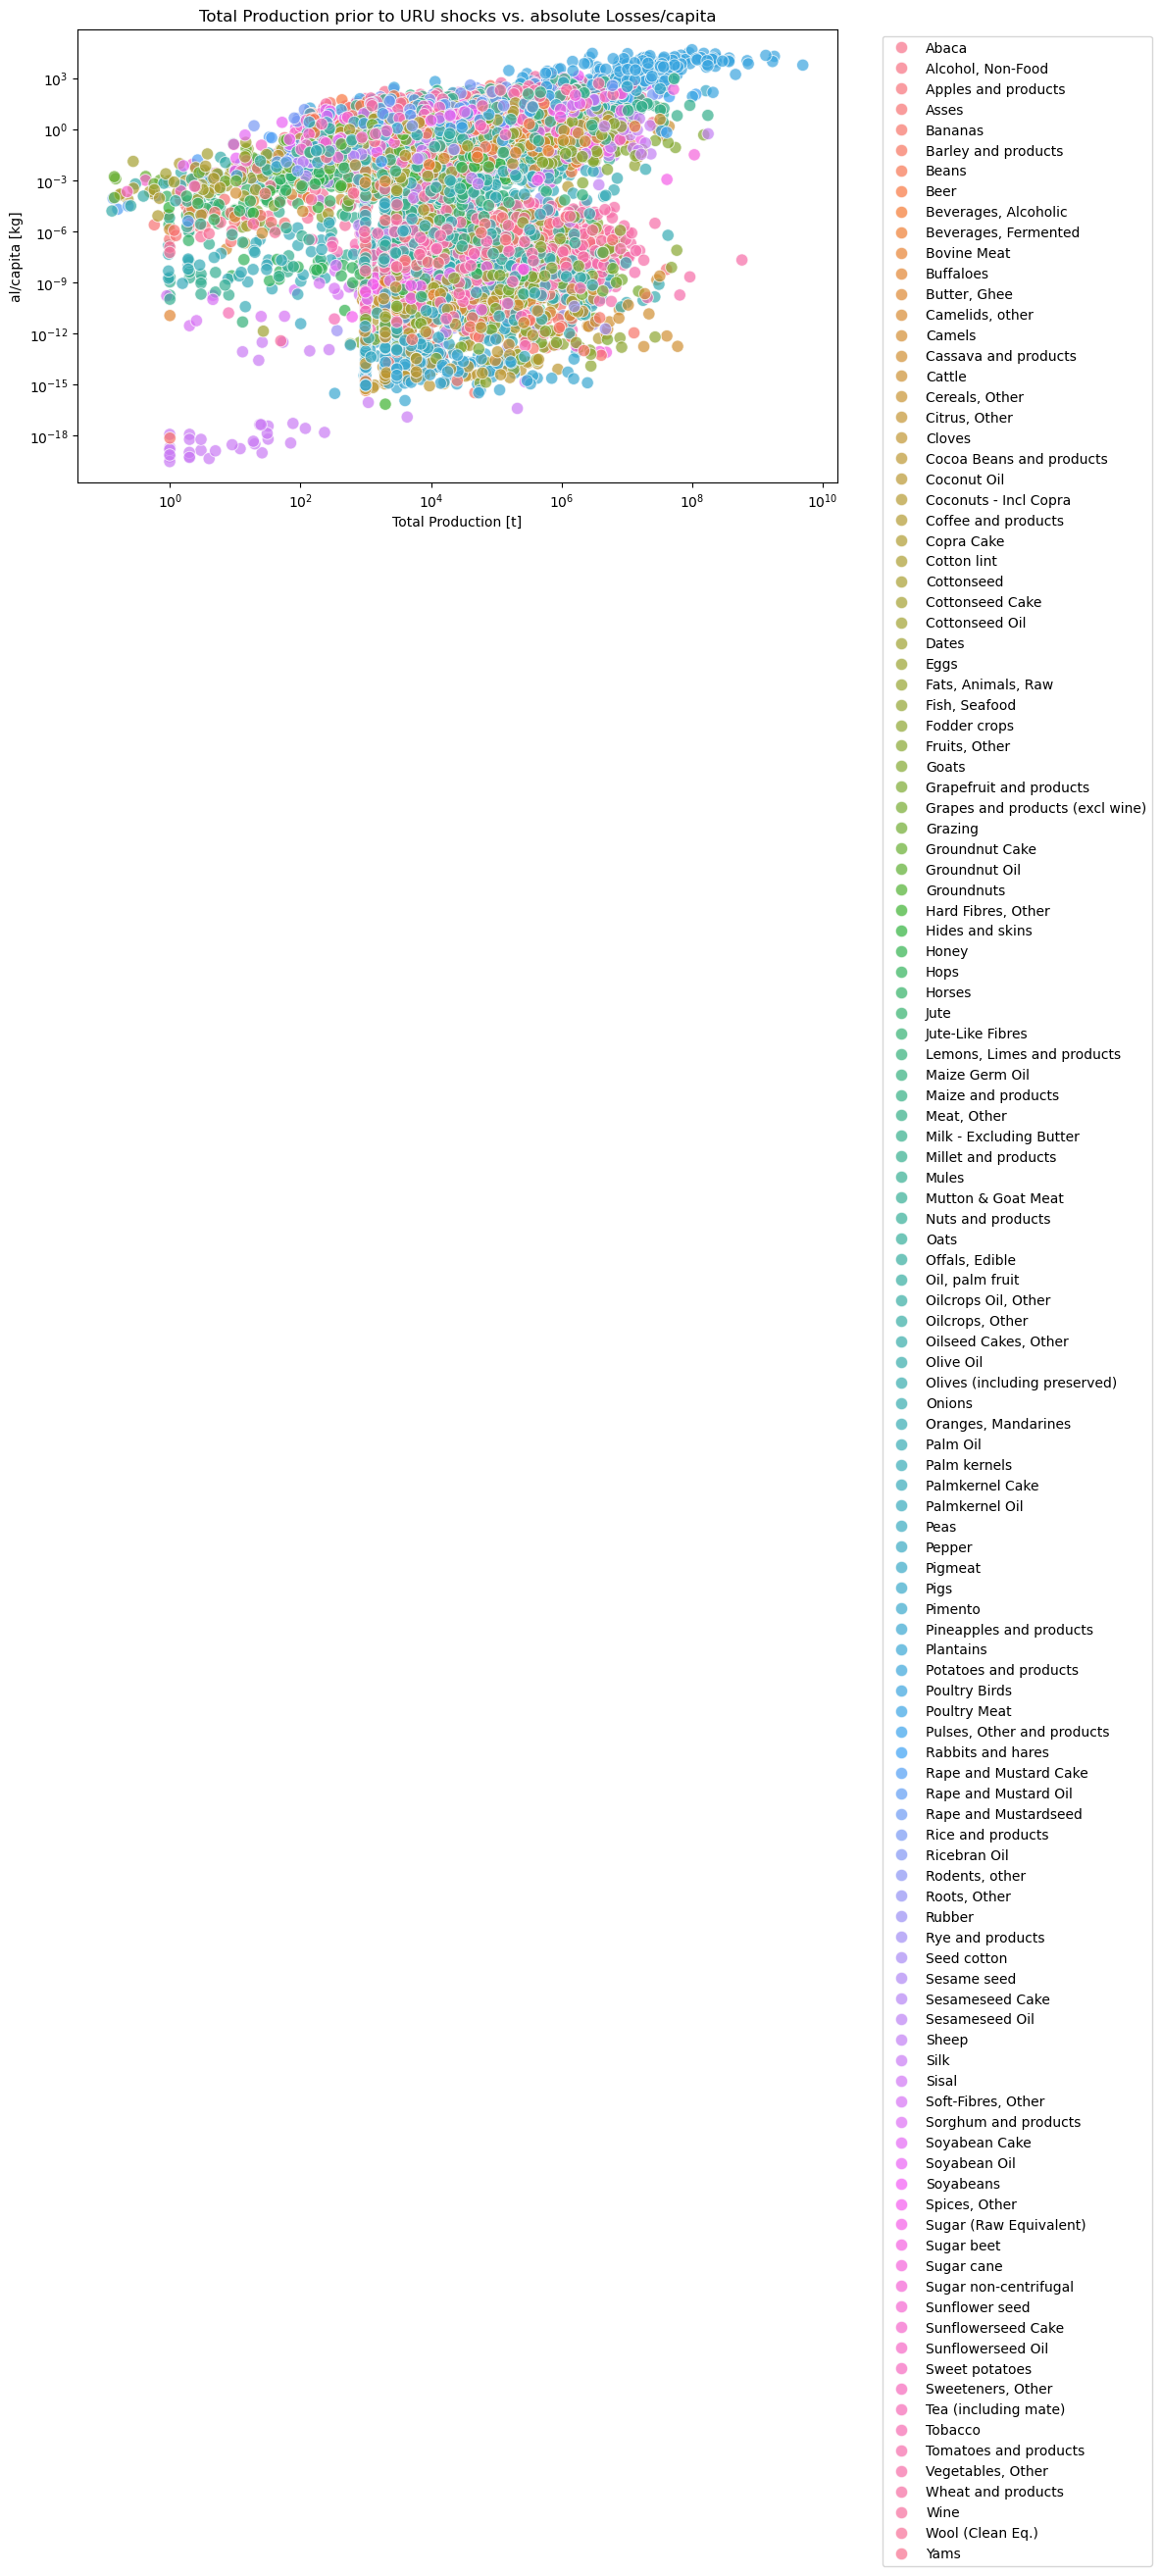

/var/folders/fc/k0ssmt390m779swj1xmy_6lw0000gn/T/ipykernel_9332/2651376458.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



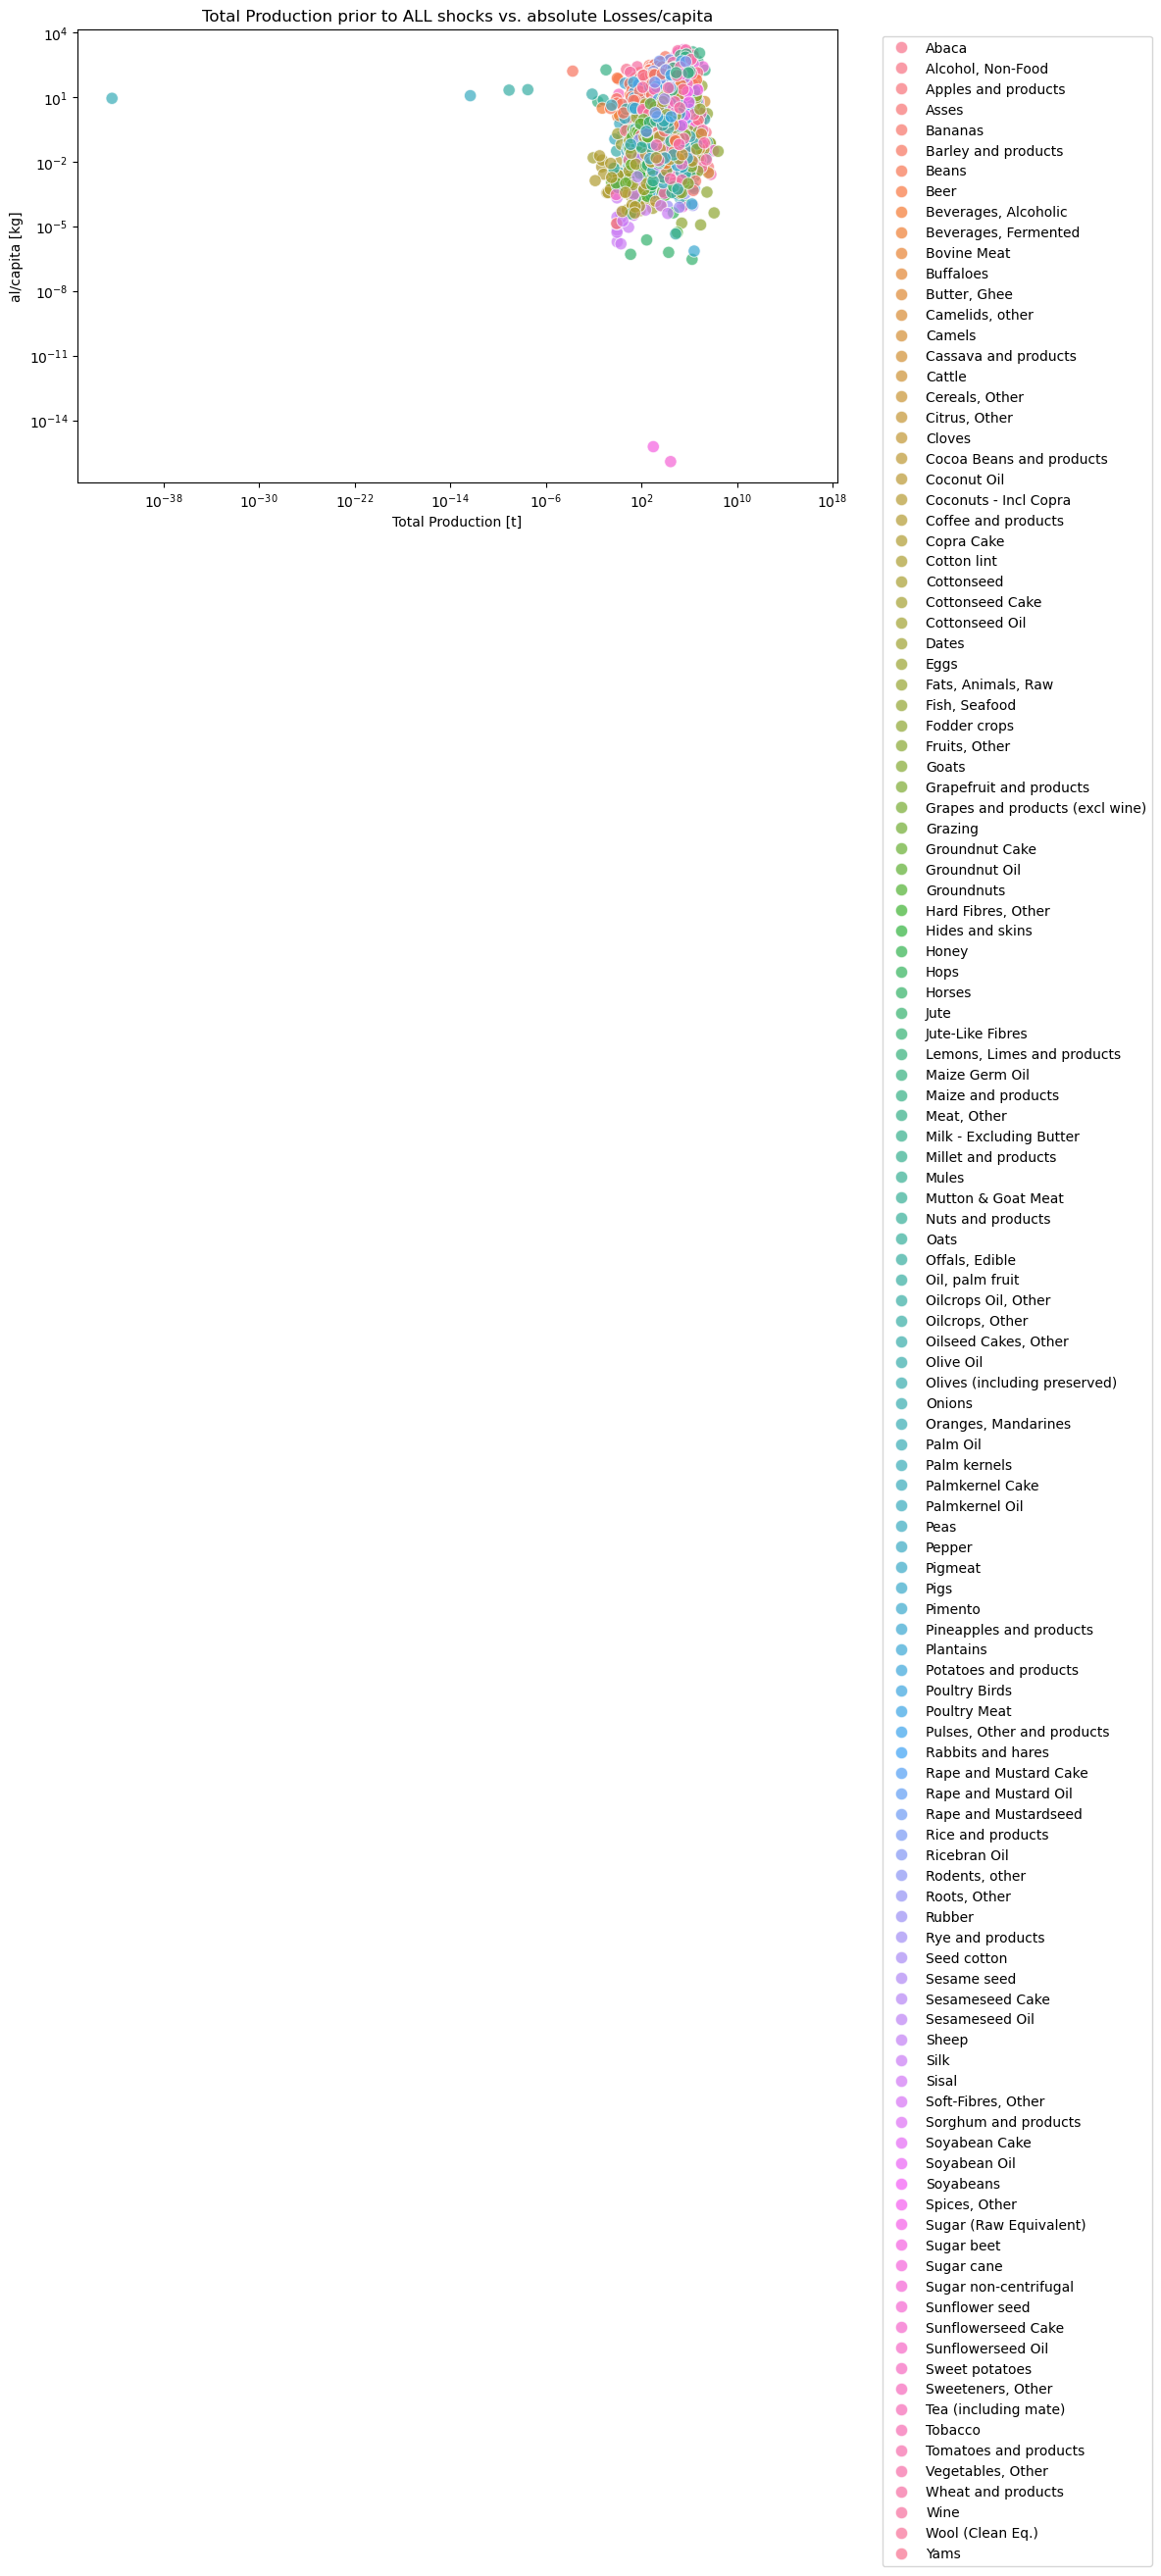

In [26]:

for i in range(len(scenario)):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df[i],
        x='amount [t]',
        y='al/capita [kg]',
        hue='item',
        alpha=0.7,
        edgecolor='w',
        s=80
    )

    plot_title = f"Total Production prior to {scenario[i]} shocks vs. absolute Losses/capita"
    plt.title(plot_title)
    plt.xlabel("Total Production [t]")
    plt.ylabel("al/capita [kg]")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()

    # Save the figure
    filename = f"scatter_al_per_capita_{scenario[i].replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)

    plt.show()

In [27]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Rice and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Rice and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [28]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Poultry Birds']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Poultry Birds' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [29]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Maize and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Maize and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [30]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Wheat and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Wheat and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()